In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

from sklearn.metrics import confusion_matrix

In [220]:
data = pd.read_csv('./dataset/titanic_train.csv')
print(data.shape)
data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [221]:
data.drop(['PassengerId', 'Name'], axis=1, inplace=True)

### Numeric attributes

In [222]:
num_vars = [var for var in data.columns if data[var].dtypes != 'O']
print('Number of numerical vars: ', len(num_vars))
num_vars

Number of numerical vars:  6


['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### Missing values

In [223]:
vars_w_na = [var for var in data if data[var].isnull().sum() > 0]

data[vars_w_na].isnull().mean()

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

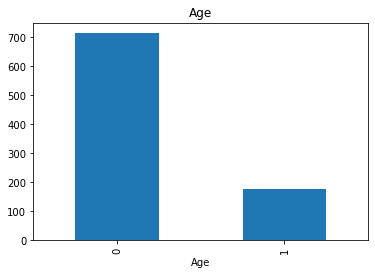

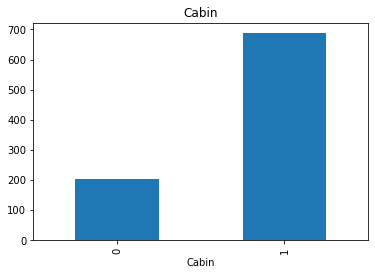

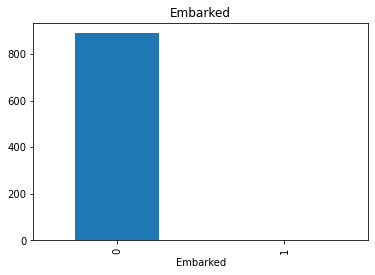

In [224]:
def visualise_missing(df, var):
    df = df.copy()
    # prepisanie premennej hodnotami 1 ak hodnota chyba 0 ak nechyba
    df[var] = np.where(df[var].isnull(), 1, 0)

    # porovnanie poctu chybajucich hodnot jednotlivych premennych
    df.groupby(var)['Survived'].count().plot.bar()
    
    # zobrazenie hodnot na grafe
    plt.title(var)
    plt.show()


# spustenie funkcie visualise_missing pre kazdy atribut kde hodnoty chybaju
for var in vars_w_na:
    visualise_missing(data, var)

# vidime, ze viac nez 3/4 dat atributu cabin chyba. Moze stat za zvazenie vynechat tento atribut.

### Distribution

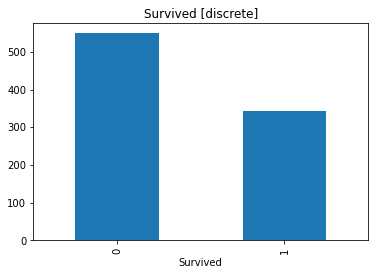

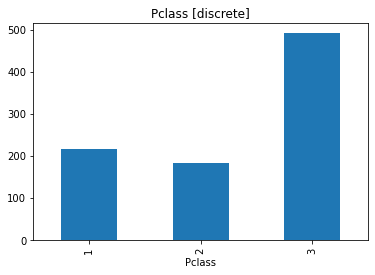

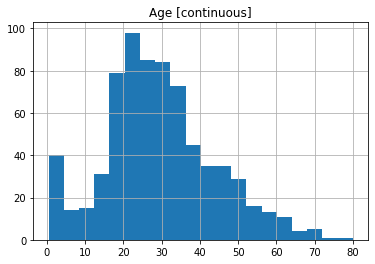

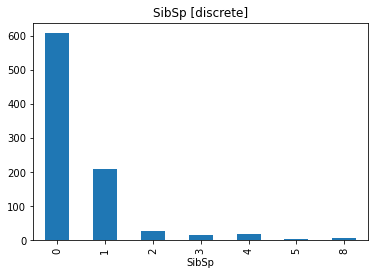

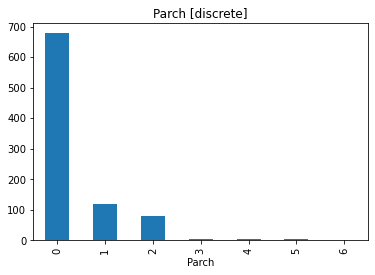

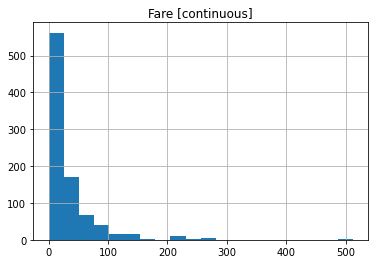

In [225]:
# Distribution of numeric values

def visualise_num_distribution(df, var):
  df = df.copy()
  if len(df[var].unique()) < 20:
    # discrete
    df.groupby(var)['Survived'].count().plot.bar()
    plt.title('{0} [discrete]'.format(var))
    plt.show()
  else:
    # continuous
    df[var].hist(bins=20)
    plt.title('{0} [continuous]'.format(var))
    plt.show()


for var in num_vars:
  visualise_num_distribution(data, var)

### New attributes

In [226]:
data['ShipPart'] = data['Cabin'].str[:1]

data = data.drop(columns=['Cabin'])

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,ShipPart
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,NaN
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,NaN
3,1,1,female,35.0,1,0,113803,53.1000,S,C
4,0,3,male,35.0,0,0,373450,8.0500,S,NaN


### Nominal attributes

In [227]:
nom_vars = [var for var in data.columns if data[var].dtypes == 'O']
print('Number of nominal vars: ', len(nom_vars))
nom_vars

Number of nominal vars:  4


['Sex', 'Ticket', 'Embarked', 'ShipPart']

### Replacing Missing values

In [228]:
vars_w_na = [var for var in data if data[var].isnull().sum() > 0]

vars_w_na


['Age', 'Embarked', 'ShipPart']

In [229]:
vars_w_na = vars_w_na[1:]
data[vars_w_na] = data[vars_w_na].fillna('Missing')
data['Age'] = data['Age'].fillna(data['Age'].mean())
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,ShipPart
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Missing
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Missing
3,1,1,female,35.0,1,0,113803,53.1000,S,C
4,0,3,male,35.0,0,0,373450,8.0500,S,Missing


### Logaritmic distribution of numeric attributes

In [230]:
for var in num_vars:
    if var in ['Survived']: continue
    data[var] = data[var].replace(0,10**-10)
    data[var] = np.log(data[var])

### Normalise attributes values

In [231]:
data_vars = [var for var in num_vars if var not in ['Survived']]

scaler = MinMaxScaler()
scaler.fit(data[data_vars]) 
data[data_vars] = scaler.transform(data[data_vars])

### Nominal to categorical

In [232]:
def replace_categories(df, var, target):
  # zoradenie hodnot premennej na zaklade priemernej ceny domov od najmensej po najvacsiu
  ordered_labels = df.groupby([var])[target].mean().sort_values().index

  # vytvorenie slovnika string - hodnota
  ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

  # nahradenie string danou hodnotou v datasete
  df[var] = df[var].map(ordinal_label)

In [233]:
for var in nom_vars:
    replace_categories(data, var, 'Survived')

### Select the most important features

In [234]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,ShipPart
0,0,1.0,0,0.754076,0.917171,0.0,332,0.854502,0,1
1,1,0.0,1,0.858189,0.917171,0.0,478,0.932605,2,4
2,1,1.0,1,0.785899,0.000000,0.0,476,0.857544,0,1
3,1,0.0,1,0.842523,0.917171,0.0,440,0.922542,0,4
4,0,1.0,0,0.842523,0.000000,0.0,11,0.858079,0,1


In [235]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['Survived'],
                                                    test_size=0.1,
                                                    # we are setting the seed here:
                                                    random_state=0)

X_train.drop(['Survived'], axis=1, inplace=True)
X_test.drop(['Survived'], axis=1, inplace=True)

C:\Users\Dominik\miniconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [236]:
sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=0))

sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [237]:
sel_.get_support()
selected_feats = X_train.columns[(sel_.get_support())]
selected_feats

Index(['Sex', 'Age', 'Ticket', 'ShipPart'], dtype='object')

In [238]:
X_test = X_test[selected_feats]
X_train = X_train[selected_feats]
X_test.head()

,Sex,Age,Ticket,ShipPart
495,0,0.811238,330,1
648,0,0.811238,221,1
278,0,0.535936,25,1
31,1,0.811238,491,6
255,1,0.806701,671,1


# Training a model

In [249]:
lin_model = LogisticRegression(random_state=0)
lin_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [250]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((801, 4), (90, 4), (801,), (90,))

In [251]:
# vyhodnotenie modelu:
# ====================
pred = lin_model.predict(X_train)

print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    sqrt(mean_squared_error(np.exp(y_train), np.exp(pred))))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

pred = lin_model.predict(X_test)

print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    sqrt(mean_squared_error(np.exp(y_test), np.exp(pred))))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

train mse: 0
train rmse: 0
train r2: 0.9203745675772397

test mse: 0
test rmse: 0
test r2: 0.9547511312217194



In [260]:
# Confusion matrix
cm = confusion_matrix(y_test, pred)
TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)
print('Accuracy of the classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  39
False Positive(FP) =  1
True Negative(TN)  =  50
False Negative(FN) =  0
Accuracy of the classification = 0.989


<AxesSubplot:>

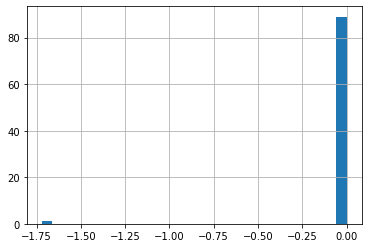

In [253]:
errors = np.exp(y_test) - np.exp(lin_model.predict(X_test))
errors.hist(bins=30)

Text(0.5, 1.0, 'Feature Importance')

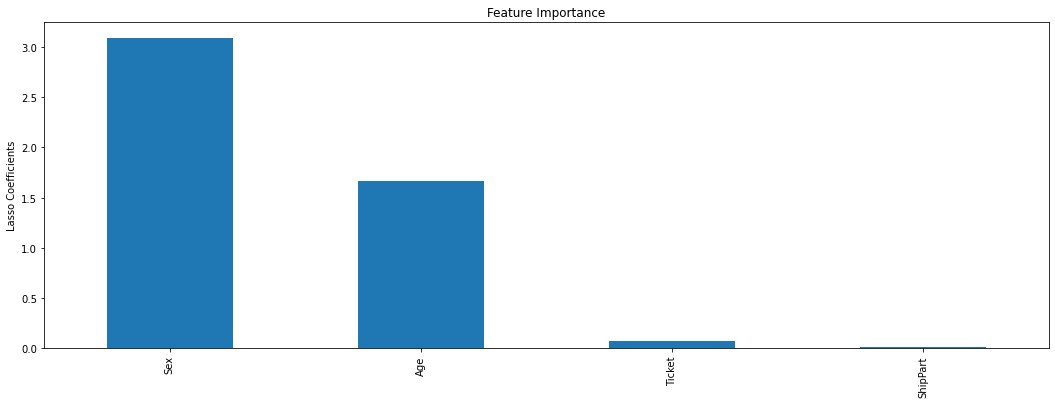

In [254]:
importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = selected_feats
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')